# Data Fusion Results are sensitive to spatial subsetting

This notebook assumes you have run cmaqml with 8 query definitions. This is the result of three binary splits with 3 splits: west/east, south/north, and urban/rural. The query definitions should be named EN_URB, WS_RUR, etc. The definitions are in the default config.json, but not enabled by default.

In [41]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import PseudoNetCDF as pnc
import pycno
from glob import glob
import cmaqml

In [51]:
cfg = cmaqml.opts.loadcfg('config.json')

In [52]:
cfg["query_definitions"].update({
        "WN_RUR": "longitude < {longitude_center} and latitude >= {latitude_center} and DENS < {urban_minimum_density}",
        "WN_URB": "longitude < {longitude_center} and latitude >= {latitude_center} and DENS >= {urban_minimum_density}",
        "WS_RUR": "longitude < {longitude_center} and latitude < {latitude_center} and DENS < {urban_minimum_density}",
        "WS_URB": "longitude < {longitude_center} and latitude < {latitude_center} and DENS >= {urban_minimum_density}",
        "EN_RUR": "longitude >= {longitude_center} and latitude >= {latitude_center} and DENS < {urban_minimum_density}",
        "EN_URB": "longitude >= {longitude_center} and latitude >= {latitude_center} and DENS >= {urban_minimum_density}",
        "ES_RUR": "longitude >= {longitude_center} and latitude < {latitude_center} and DENS < {urban_minimum_density}",
        "ES_URB": "longitude >= {longitude_center} and latitude < {latitude_center} and DENS >= {urban_minimum_density}",
        "WN_BOTH": "longitude < {longitude_center} and latitude >= {latitude_center}",
        "WS_BOTH": "longitude < {longitude_center} and latitude < {latitude_center}",
        "EN_BOTH": "longitude >= {longitude_center} and latitude >= {latitude_center}",
        "ES_BOTH": "longitude >= {longitude_center} and latitude < {latitude_center}",
        "ALL_URB": "DENS >= {urban_minimum_density}",
        "ALL_RUR": "DENS < {urban_minimum_density}",
        "ALL": "longitude == longitude"  
})
cfg.update({
    "longitude_center": -97,
    "latitude_center": 40,
    "urban_minimum_density": 100
})


In [53]:
outpaths = cmaqml.driver.run(cfg, verbose=0)

Retaining latitude
Retaining longitude
Retaining Y
Retaining X


In [54]:
outpaths

{'ALL': ['output/UK.20160715.ALL.prod.nc'],
 'ALL_RUR': ['output/UK.20160715.ALL_RUR.prod.nc'],
 'ALL_URB': ['output/UK.20160715.ALL_URB.prod.nc'],
 'EN_BOTH': ['output/UK.20160715.EN_BOTH.prod.nc'],
 'EN_RUR': ['output/UK.20160715.EN_RUR.prod.nc'],
 'EN_URB': ['output/UK.20160715.EN_URB.prod.nc'],
 'ES_BOTH': ['output/UK.20160715.ES_BOTH.prod.nc'],
 'ES_RUR': ['output/UK.20160715.ES_RUR.prod.nc'],
 'ES_URB': ['output/UK.20160715.ES_URB.prod.nc'],
 'WN_BOTH': ['output/UK.20160715.WN_BOTH.prod.nc'],
 'WN_RUR': ['output/UK.20160715.WN_RUR.prod.nc'],
 'WN_URB': ['output/UK.20160715.WN_URB.prod.nc'],
 'WS_BOTH': ['output/UK.20160715.WS_BOTH.prod.nc'],
 'WS_RUR': ['output/UK.20160715.WS_RUR.prod.nc'],
 'WS_URB': ['output/UK.20160715.WS_URB.prod.nc']}

In [55]:
allf = pnc.pncopen(outpaths['ALL'][0], format='ioapi')
popf = pnc.pncopen('input/gpw_v4_une_atotpopbt_densy_108US2.IOAPI.nc', format='ioapi')
DENS = popf.variables['DENS'][3, 0]
I, J = np.meshgrid(np.arange(allf.NCOLS), np.arange(allf.NROWS))
lon, lat = allf.ij2ll(I, J)
# The split between urban and non urban in the config file is 100/km2
# Below 15, it is definitely rural. Above 200, definitely urban
# Beteween the two, linearly interpolate
urbw = np.interp(DENS, [15, 200], [0, 1])
rurw = 1 - urbw
eastw = np.interp(lon, [-102, -92], [0, 1])
westw = 1 - eastw
northw = np.interp(lat, [35, 45], [0, 1])
southw = 1 - northw


In [56]:
def blender(outf, blendopts):
    wv = outf.createVariable('WEIGHTS', 'f', ('TSTEP', 'LAY', 'ROW', 'COL'))
    for w, inkey in blendopts:
        tmpf = pnc.pncopen(outpaths[inkey][0], format='ioapi')
        outf.variables['Y'][:] += tmpf.variables['Y'][:] * w
        outf.variables['Q'][:] += tmpf.variables['Q'][:] * w
        outf.variables['UK_TOTAL'][:] += tmpf.variables['UK_TOTAL'][:] * w
        wv[:] += w

In [57]:
blenders = {
    'BLENDEWNS_URBRUR': [
        (urbw * eastw * northw, 'EN_URB'),
        (urbw * westw * northw, 'WN_URB'),
        (urbw * eastw * southw, 'ES_URB'),
        (urbw * westw * southw, 'WS_URB'),
        (rurw * eastw * northw, 'EN_RUR'),
        (rurw * westw * northw, 'WN_RUR'),
        (rurw * eastw * southw, 'ES_RUR'),
        (rurw * westw * southw, 'WS_RUR'),
    ],
}
blended = {}
for blendkey, blendopts in blenders.items():
    blended[blendkey] = outf = allf.copy(data=False)
    blender(outf, blendopts)

/home/bhenders/.local/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  # Remove the CWD from sys.path while we load stuff.


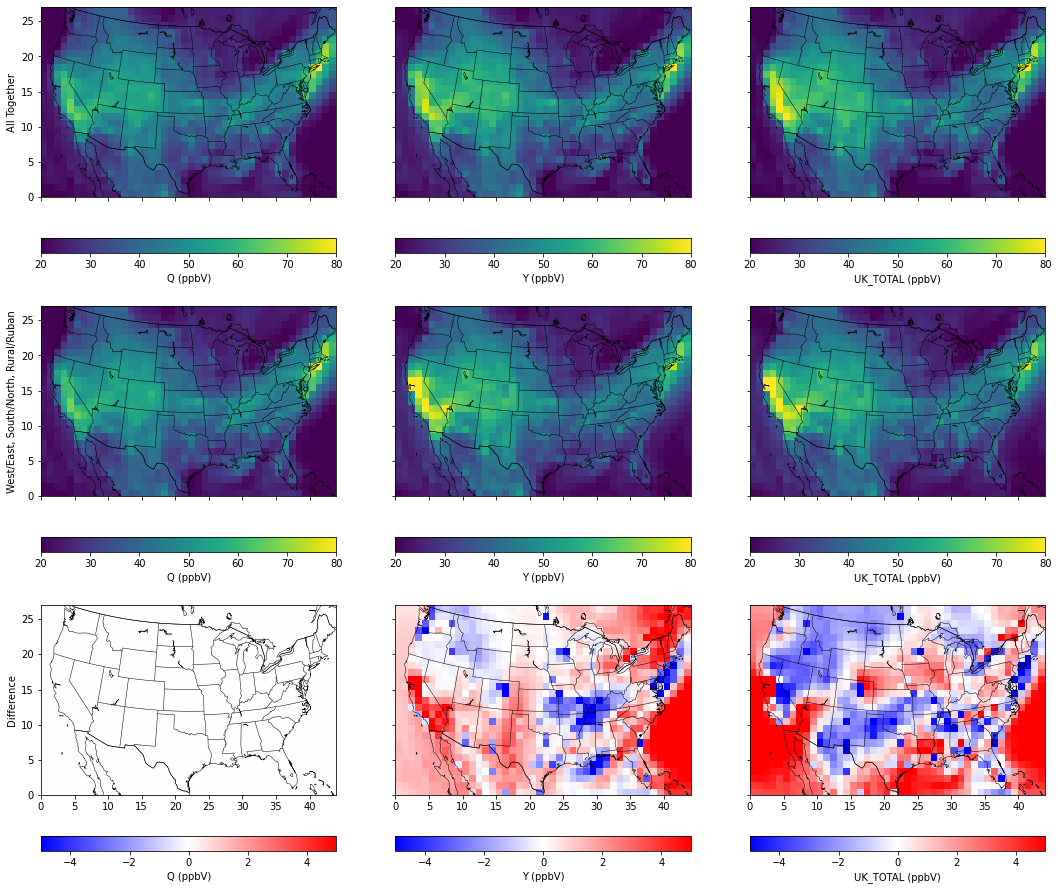

In [62]:
cno = pycno.cno(proj=allf.getproj(withgrid=True))
qnorm = plt.Normalize(vmin=20, vmax=80)
#qnorm = plt.matplotlib.colors.LogNorm(vmin=1, vmax=20)
dnorm = plt.Normalize(vmin=-5, vmax=5)

fig, axx = plt.subplots(
    3, 3, figsize=(18, 16), sharex=True, sharey=True,
    gridspec_kw=dict(hspace=.1)
)
unit = allf.variables['Q'].units.strip()
for ax, vkey in zip(axx[0], ['Q', 'Y', 'UK_TOTAL']):
    p = ax.pcolormesh(allf.variables[vkey][0, 0], cmap='viridis', norm=qnorm)
    fig.colorbar(p, ax=ax, label=f'{vkey} ({unit})', orientation='horizontal')
for ax, vkey in zip(axx[1], ['Q', 'Y', 'UK_TOTAL']):   
    p = ax.pcolormesh(blended['BLENDEWNS_URBRUR'].variables[vkey][0, 0], cmap='viridis', norm=qnorm)
    fig.colorbar(p, ax=ax, label=f'{vkey} ({unit})', orientation='horizontal')

for ax, vkey in zip(axx[2], ['Q', 'Y', 'UK_TOTAL']):   
    p = ax.pcolormesh(blended['BLENDEWNS_URBRUR'].variables[vkey][0, 0] - allf.variables[vkey][0, 0], cmap='bwr', norm=dnorm)
    fig.colorbar(p, ax=ax, label=f'{vkey} ({unit})', orientation='horizontal')

#p = axx[2].pcolormesh(allf.variables['UK_ERROR'][0, 0], cmap='bwr')
#fig.colorbar(p, ax=axx[2], label='ERR (ppb)')
for ax in axx.ravel():
    cno.draw('MWDB_Coasts_USA_3.cnob', ax=ax)
    
axx[0, 0].set_ylabel('All Together')
axx[1, 0].set_ylabel('West/East, South/North, Rural/Ruban');
axx[2, 0].set_ylabel('Difference');
